In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\jimmy\AppData\Local\Temp\ipykernel_21932\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Finding how Measurement table is structured
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x25f9815f9a0>,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1}

In [10]:
# Find the most recent date in the data set.
for row in session.query(Measurement.date).\
    order_by(Measurement.date.desc()).\
        limit(1):
    print(row)


('2017-08-23',)


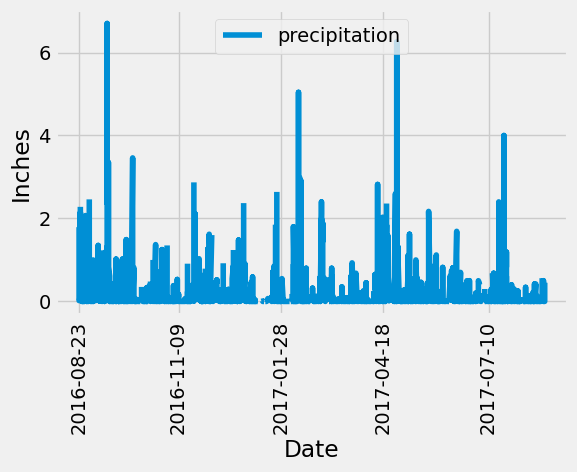

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date_str = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

most_recent_date = dt.datetime.strptime(most_recent_date_str, "%Y-%m-%d")

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days = 365)
one_year_ago_formatted = one_year_ago.strftime("%Y-%m-%d")

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(
    Measurement.date >= one_year_ago_formatted).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(results,columns=['date','precipitation'])

# Convert the 'date' column to datetime format
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# Sort the dataframe by date
precipitation_df  = precipitation_df.sort_values('date')

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(6,5))
plt.plot(precipitation_df['date'], precipitation_df['precipitation'], linestyle = '-', label= 'precipitation')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc='upper center')
specific_dates = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(pd.to_datetime(specific_dates), rotation=90)
plt.tight_layout()
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_precipitation = precipitation_df['precipitation'].describe()
summary_precipitation_df = pd.DataFrame(summary_precipitation)
summary_precipitation_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station.station).count()
total_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).all()

active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == 'USC00519281').one()

temp_stats

(54.0, 85.0, 71.66378066378067)

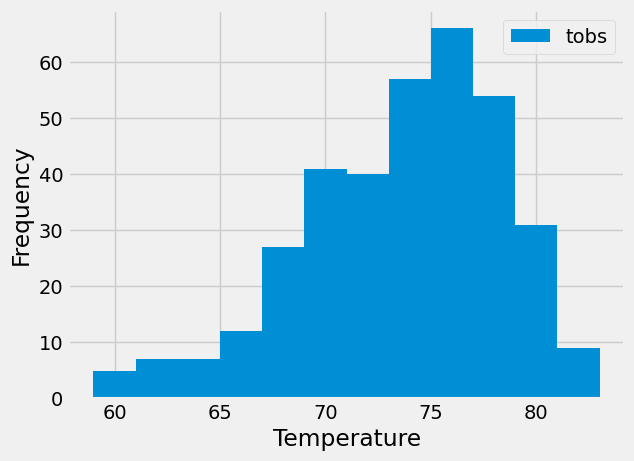

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
latest_date = session.query(func.max(Measurement.date)).filter(Measurement.station == 'USC00519281').scalar()

# Calculate the date one year before the latest date
one_year_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.tobs).filter(
    Measurement.station == 'USC00519281',
    Measurement.date >= one_year_ago
).all()

temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram with 12 bins (one for each month)
plt.hist(temperatures, bins=12, label = 'tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

# Close Session

In [17]:
# Close Session
session.close()